In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
import re
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Importing Dataset
Ticket_df=pd.read_csv("/content/supportTicketData.csv",encoding='latin1')

print(Ticket_df.shape)
Ticket_df.head(5)

(19796, 2)


,body,urgency
0,connection issues with assigned address hi fac...,P1
1,cannot access hi cannot access fallowing link ...,P2
2,re address shown valid dear colleagues remarke...,P1
3,sent tuesday critical alert following alert oc...,P2
4,code spelling mistake hello should discover fo...,P2


In [5]:
import os
os.getcwd()

'/content'

### Text Formatting to remove useless data

In [4]:
# Defining function to remove special characters and stopwords
def str_format(inp): 
    inp=re.sub(r'[^a-z A-Z 0-9]',r' ',inp)
    inp=re.sub(r'\b\w{1,3}\b',r' ',inp) # Removing Words with length less than or equal 3 these are mostly stopwords
    inp=re.sub(r' +',' ',inp)
    return inp.strip()

Ticket_df['body']=Ticket_df['body'].apply(str_format)
Ticket_df['body']=Ticket_df['body'].apply(lambda x:x.lower())

Ticket_df['body'].head()

0    connection issues with assigned address facing...
1    cannot access cannot access fallowing link bla...
2    address shown valid dear colleagues remarked n...
3    sent tuesday critical alert following alert oc...
4    code spelling mistake hello should discover co...
Name: body, dtype: object

### Converting the Textual data to vectors using TF-IDF Vectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf=TfidfVectorizer()

X=tf.fit_transform(Ticket_df['body'].values).toarray()
print(X.shape)
print(tf.get_feature_names()[:20]) # getting some selected features

(19796, 8864)
['abandon', 'abandoned', 'abeam', 'abilities', 'ability', 'able', 'abnormal', 'abnormally', 'aboard', 'abort', 'aborted', 'aborting', 'about', 'above', 'abroad', 'absence', 'absences', 'absent', 'absolutely', 'absorption']


* Creating Vectorized Dataframe

In [6]:
Vectorized_df=pd.DataFrame(X,columns=tf.get_feature_names())
Vectorized_df['Ticket_Priority']=Ticket_df['urgency']
Vectorized_df.head()

,abandon,abandoned,abeam,abilities,ability,able,abnormal,abnormally,aboard,abort,aborted,aborting,about,above,abroad,absence,absences,absent,absolutely,absorption,absurdly,abuse,academy,accelerate,accelerated,accelerates,accelerator,accept,acceptable,acceptance,accepted,accepting,accepts,access,accessed,accesses,accessibility,accessible,accessing,accessories,...,written,wrong,wrongful,wrongfully,wrongly,wrote,xerox,xmas,yale,yammer,yard,yeah,year,yearly,years,yeas,yell,yellow,yesterday,yesterdays,yoga,yoke,your,yours,yourself,yourselves,yugoslavia,zealand,zebra,zephyr,zero,zeus,zipped,zipper,zipping,zone,zones,zoom,zooming,Ticket_Priority
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.35306,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061872,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093835,0.062959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062853,0.0,0.0,0.0,0.040817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P2


### Applying PCA to reduce the Dimensions of data
* Since Data has high Dimensionality it can carry curse of dimensionality and affect the model hence we have to reduce the dimension of data using Principle Components 

In [7]:
from sklearn.decomposition import PCA

pca=PCA(n_components=5000)
pca_fit=pca.fit(X) 
pca_fit.transform(X)

array([[-4.66760901e-02, -4.59748084e-04, -1.18842144e-01, ...,
         8.34167961e-05, -2.39839823e-04, -2.32666468e-03],
       [-5.38799464e-02,  8.08283599e-02, -1.20674394e-01, ...,
        -5.79428905e-04, -9.03959382e-04, -6.27345777e-04],
       [-4.48110427e-02,  1.59362484e-02, -6.66993044e-02, ...,
         1.54048976e-03, -2.06080108e-03, -4.29884562e-04],
       ...,
       [ 2.63937564e-02, -8.15855708e-02,  1.87993973e-02, ...,
        -3.77741002e-06, -1.27969000e-05, -1.31165373e-05],
       [ 5.92423512e-02, -8.10578934e-02,  1.75678276e-02, ...,
         2.68306831e-03,  1.11078035e-03,  1.23552298e-04],
       [ 1.14787278e-02, -7.69375042e-02, -6.76223226e-03, ...,
        -4.41303341e-04,  7.46104690e-04,  8.66011644e-04]])

[ 1.32  2.35  3.16 ... 95.59 95.59 95.59]


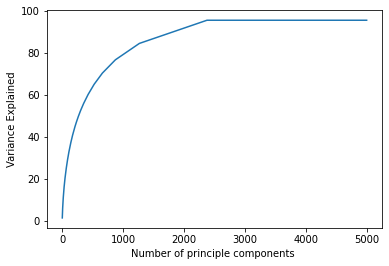

In [41]:
var_exp=np.cumsum(np.round(pca.explained_variance_ratio_,4)*100)
pd.Series(var_exp).plot()
plt.xlabel("Number of principle components ")
plt.ylabel("Variance Explained")
print(var_exp)

* Nearly 2300 Principle components are good to covere maximum Variance in Data 
* Generating 2300 pca for which can be used for final model

In [45]:
pc=PCA(n_components=2300)

pc_components=pc.fit_transform(X)

In [60]:
preds=pd.Series(["pc_"]*2300).str.cat(pd.Series(np.arange(2300)).apply(str))
principle_data=pd.DataFrame(pc_components,columns=preds)
principle_data.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19,pc_20,pc_21,pc_22,pc_23,pc_24,pc_25,pc_26,pc_27,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,...,pc_2260,pc_2261,pc_2262,pc_2263,pc_2264,pc_2265,pc_2266,pc_2267,pc_2268,pc_2269,pc_2270,pc_2271,pc_2272,pc_2273,pc_2274,pc_2275,pc_2276,pc_2277,pc_2278,pc_2279,pc_2280,pc_2281,pc_2282,pc_2283,pc_2284,pc_2285,pc_2286,pc_2287,pc_2288,pc_2289,pc_2290,pc_2291,pc_2292,pc_2293,pc_2294,pc_2295,pc_2296,pc_2297,pc_2298,pc_2299
0,-0.046676,-0.000460,-0.118842,0.008565,0.047660,-0.012283,-0.012815,-0.087080,-0.091439,-0.059403,0.113773,-0.085760,0.025544,0.021007,0.066046,-0.071663,0.064630,0.053298,0.023345,-0.037445,0.013894,-0.018270,-0.003134,-0.111204,0.030368,-0.021287,-0.080232,-0.017718,-0.089192,0.019197,0.015063,0.164377,-0.022103,0.042540,0.002578,0.099267,0.073421,0.043359,0.043809,-0.024791,...,0.004265,0.000603,-0.007823,-0.001390,0.001125,-0.004498,0.003099,0.002068,0.004722,-0.001645,0.005230,-0.002699,0.001083,0.006148,0.004274,0.001520,0.005506,0.005186,-0.000829,-0.003706,0.002937,-0.001220,-0.001318,0.007203,-0.000571,0.001240,0.000265,-0.002199,-0.000830,-0.000661,-0.006375,-0.007331,0.010238,-0.002001,0.000487,0.008006,-0.005538,0.000956,-0.002322,-0.003375
1,-0.053880,0.080828,-0.120674,0.210051,0.006922,0.029643,0.029543,0.190969,0.057509,0.003966,0.074341,-0.003876,-0.144540,-0.006603,-0.027528,-0.040770,0.073570,0.057054,-0.051338,-0.120964,-0.022019,-0.084234,0.047946,0.030942,0.036498,-0.066432,0.071101,-0.048672,-0.010441,0.038574,0.096340,-0.069704,0.043969,-0.194863,0.164602,-0.012496,0.061018,0.039156,-0.175136,0.111419,...,-0.004457,-0.001436,0.001212,-0.003310,-0.002543,-0.000531,0.002344,0.002029,-0.001123,0.001265,-0.000868,0.000059,0.001246,0.000323,-0.000631,-0.002141,0.005616,-0.001242,-0.000782,-0.002075,0.001294,-0.003398,0.002570,-0.002481,0.003346,-0.001429,-0.004729,-0.002500,-0.002675,-0.001486,-0.001563,-0.002662,-0.001891,-0.003069,-0.002428,0.000706,-0.000735,-0.000374,-0.004262,0.001929
2,-0.044811,0.015936,-0.066699,-0.003985,0.064791,-0.013852,-0.025388,0.000744,-0.006917,-0.043467,0.001215,-0.036276,0.033832,0.032946,0.111774,-0.011476,0.081471,-0.046883,0.019359,-0.016031,0.037840,0.020474,0.040478,-0.040333,-0.044040,0.053528,-0.015924,0.003844,0.012743,-0.028708,-0.113175,0.073795,0.017104,-0.000124,0.059413,0.078754,0.056872,-0.019674,0.090303,0.044930,...,0.002881,0.006283,-0.002881,0.011406,-0.003134,0.006117,-0.013869,0.013442,0.001703,-0.009394,0.003540,-0.005086,-0.004660,-0.011454,-0.007674,-0.003111,-0.000884,0.005207,0.002435,-0.008213,0.000487,0.001592,-0.003660,0.016177,-0.004197,-0.009792,0.000705,-0.008306,0.007021,-0.006013,-0.006238,-0.005978,0.002101,-0.003874,0.005905,-0.005635,-0.013366,0.004185,-0.012445,0.005499
3,-0.011736,-0.027293,0.034007,0.005151,0.155100,-0.248436,-0.026718,0.014621,0.057329,-0.076923,-0.361061,0.261961,0.049329,-0.143463,0.324112,-0.190811,-0.139273,-0.067120,0.188197,-0.232407,-0.027411,-0.165328,0.136582,0.065600,0.078284,-0.020910,0.076940,-0.043992,-0.043131,-0.027070,0.065245,0.056193,-0.020072,0.105557,0.031691,-0.058311,-0.094253,-0.085340,0.052386,-0.059528,...,-0.003541,0.010807,0.004470,0.000973,-0.006772,-0.006724,0.000692,0.003470,-0.004357,0.021801,0.014121,0.000680,-0.001349,-0.001775,-0.005011,-0.001538,0.001357,0.000474,-0.001404,-0.002343,0.005411,0.000119,0.010436,0.002888,-0.002389,-0.002183,0.009285,-0.009313,-0.002432,0.002071,-0.006833,-0.006342,-0.009122,0.002123,-0.004987,0.000625,0.002618,0.000665,0.004283,-0.013316
4,0.018313,-0.090123,0.024021,-0.059203,-0.061587,-0.006362,-0.015614,0.112252,-0.031677,-0.108528,0.075326,0.066660,0.042390,0.139461,0.027452,0.013413,-0.033606,0.054348,-0.094990,-0.101740,-0.088907,0.012181,-0.035996,0.070167,0.073105,-0.046049,-0.118264,0.215862,-0.056588,0.140605,0.010508,-0.000425,0.009391,-0.010630,-0.020791,0.007146,-0.016197,-0.005290,0.067633,0.0

### Preparing Data for ML

* Extracting Data for ML

In [69]:
Ticket_df['urgency'].unique()

array(['P1', 'P2', 'P3'], dtype=object)

In [70]:
Data_ML_X=pc_components
Data_ML_y=Ticket_df['urgency'].values


* Standardizing/Normalizing and Splitting Data into Train and Test

In [73]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Data_ML_X=MinMaxScaler().fit_transform(Data_ML_X)

X_train,X_test,y_train,y_test=train_test_split(Data_ML_X,Data_ML_y,test_size=0.3,random_state=457)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape,sep='\n')

(13857, 2300)
(5939, 2300)
(13857,)
(5939,)


#### We Can Create Following Models on High Dimensional Data for good speed
* Naive Bayes
* Logistic Regression


### Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression

LR=LogisticRegression(C=5,penalty="l2",solver='saga',random_state=456)
LR.fit(X_train,y_train)


LogisticRegression(C=5, random_state=456, solver='saga')

In [77]:
from sklearn.metrics import f1_score,classification_report,accuracy_score
pred_LR=LR.predict(X_test)

print(classification_report(y_test,pred_LR))
print("F1 score of Test data is : ",f1_score(y_test,pred_LR,average='weighted'))
print("Accuracy Score on Test Data :",accuracy_score(y_test,pred_LR))


              precision    recall  f1-score   support

          P1       0.65      0.66      0.65      2037
          P2       0.57      0.53      0.55      1678
          P3       0.94      0.98      0.96      2224

    accuracy                           0.74      5939
   macro avg       0.72      0.72      0.72      5939
weighted avg       0.74      0.74      0.74      5939

F1 score of Test data is :  0.7393352473866013
Accuracy Score on Test Data : 0.7428860077454117


### Naive Bayes

In [82]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
NB=GaussianNB()
# NB=MultinomialNB()

NB.fit(X_train,y_train)

pred_naive=NB.predict(X_test)

print(classification_report(y_test,pred_naive))
print("F1 score of Test data is : ",f1_score(y_test,pred_naive,average='weighted'))
print("Accuracy Score on Test Data :",accuracy_score(y_test,pred_naive))


              precision    recall  f1-score   support

          P1       0.40      0.40      0.40      2037
          P2       0.32      0.39      0.35      1678
          P3       0.46      0.39      0.43      2224

    accuracy                           0.40      5939
   macro avg       0.40      0.40      0.39      5939
weighted avg       0.40      0.40      0.40      5939

F1 score of Test data is :  0.39806148615714904
Accuracy Score on Test Data : 0.3960262670483246
